# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from GEModel import GEModelClass

In [2]:
model = GEModelClass('baseline')
print(model)

Modelclass: GEModelClass

Parameters:
 sigma = 2.0 [float64]
 beta = 0.96 [float64]
 r = 0.03 [float64]
 w = 1.0 [float64]
 rho = 0.97 [float64]
 sigma_e = 0.25 [float64]
 Ne = 5 [int64]
 a_max = 200.0 [float64]
 Na = 500 [int64]
 simN = 1000000 [int64]
 max_iter_solve = 5000 [int64]
 max_iter_simulate = 5000 [int64]
 solve_tol = 1e-08 [float64]
 simulate_tol = 0.0001 [float64]
 a_grid = array(float64, 1d, C) with shape = (500,)
 e_grid = array(float64, 1d, C) with shape = (5,)
 e_trans = array(float64, 2d, C) with shape = (5, 5)
 e_ergodic = array(float64, 1d, C) with shape = (5,)
 e_trans_cumsum = array(float64, 2d, C) with shape = (5, 5)
 e_ergodic_cumsum = array(float64, 1d, C) with shape = (5,)
memory, gb: 0.0

Solution:
 a = array(float64, 2d, C) with shape = (5, 500)
 m = array(float64, 2d, C) with shape = (5, 500)
 c = array(float64, 2d, C) with shape = (5, 500)
 V = array(float64, 2d, C) with shape = (5, 500)
 Va = array(float64, 2d, C) with shape = (5, 500)
memory, gb: 0.0

S

**Productivity states:**

In [3]:
par = model.par
sol = model.sol
sim = model.sim

for e,pr_e in zip(par.e_grid,par.e_ergodic):
    print(f'Pr[e = {e:.4f}] = {pr_e:.4f}')
    
assert np.isclose(np.sum(par.e_grid*par.e_ergodic),1.0)

Pr[e = 0.5879] = 0.0625
Pr[e = 0.7549] = 0.2500
Pr[e = 0.9693] = 0.3750
Pr[e = 1.2446] = 0.2500
Pr[e = 1.5981] = 0.0625


# Solve

In [4]:
model.solve(do_print=True)

household problem solved in 4.4 secs [431 iterations]
[value function abs. max diff. is 0.00000000]


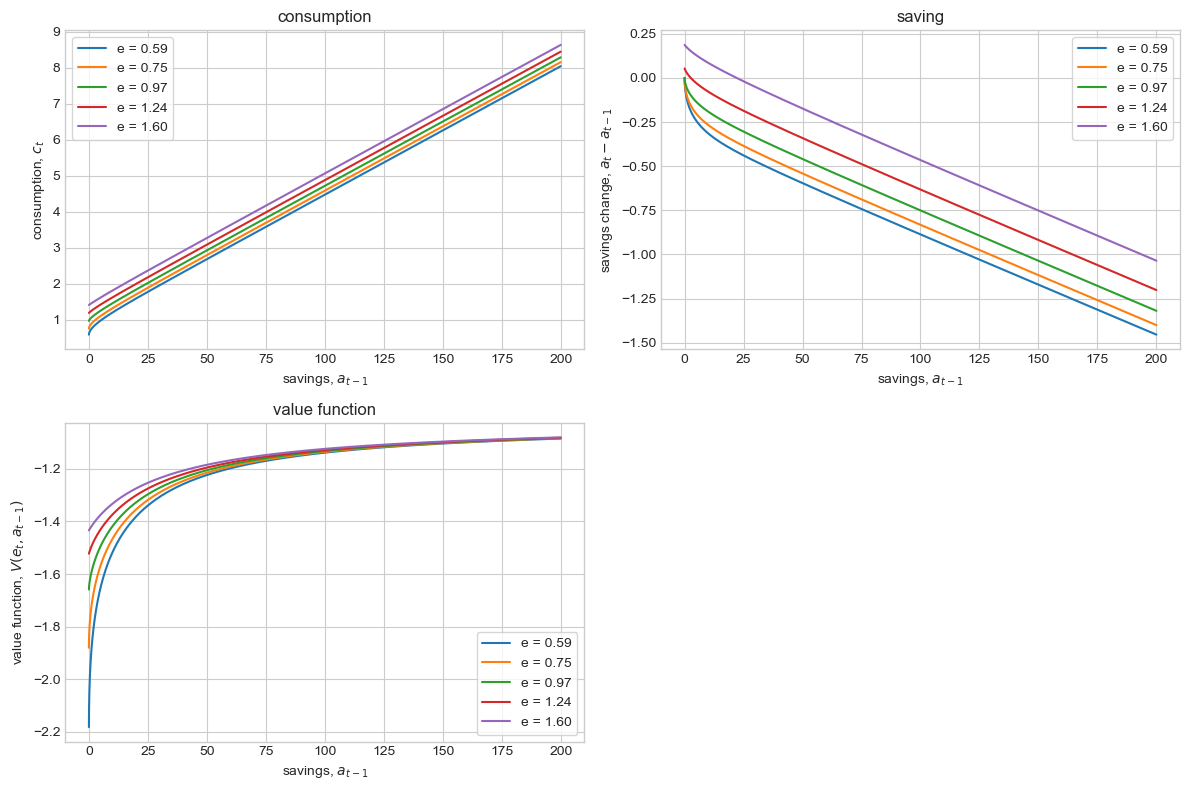

In [5]:
fig = plt.figure(figsize=(12,8),dpi=100)

# a. consumption
ax = fig.add_subplot(2,2,1)
ax.set_title('consumption')

for i_e,e in enumerate(par.e_grid):
    ax.plot(par.a_grid,sol.c[i_e,:],label=f'e = {e:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
ax = fig.add_subplot(2,2,2)
ax.set_title('saving')

for i_e,e in enumerate(par.e_grid):
    ax.plot(par.a_grid,sol.a[i_e,:]-par.a_grid,label=f'e = {e:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')

# c. saving
ax = fig.add_subplot(2,2,3)
ax.set_title('value function')

for i_e,e in enumerate(par.e_grid):
    ax.plot(par.a_grid,sol.V[i_e],label=f'e = {e:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('value function, $V(e_t,a_{t-1})$')

fig.tight_layout()

# Test of matrix-form

**Define matrices:**

In [6]:
Q = np.identity(par.Ne*par.Na) # wrong content
Pit = np.identity(par.Ne*par.Na) # wrong content

**Calculate $\Omega$**

In [7]:
Omega = Q@Pit

**Test:**

In [8]:
v_vec = np.reshape(sol.V,(par.Ne*par.Na,1))
c_vec = np.reshape(sol.c,(par.Ne*par.Na,1))
u_vec = c_vec**(1-par.sigma)/(1-par.sigma)
v_vec_next = u_vec + par.beta*Omega@v_vec
max_abs_diff = np.max(np.abs(v_vec-v_vec_next))
print(f'We should max_abs_diff = 0.0')
print(f'We have max_abs_diff   = {max_abs_diff:.8f}')

We should max_abs_diff = 0.0
We have max_abs_diff   = 1.61363019


# Simulate

In [9]:
model.simulate(do_print=True)

household problem simulated in 21.9 secs [231 iterations]


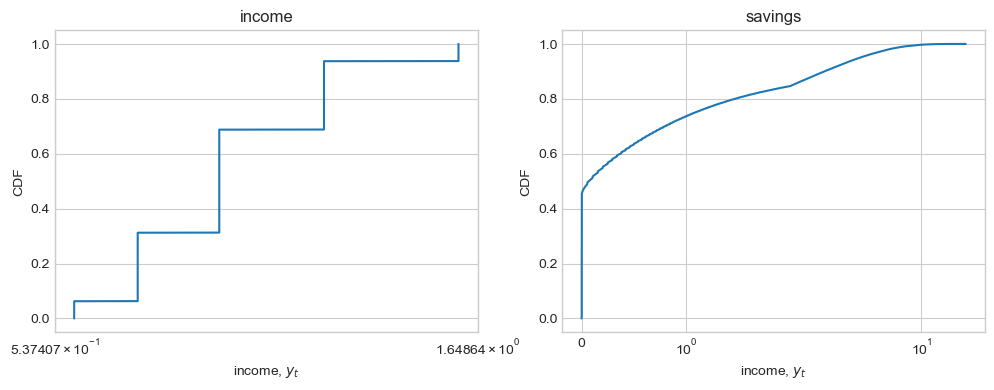

In [10]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('income')
ax.plot(np.sort(sim.y),np.arange(par.simN)/par.simN)
ax.set_xlabel('income, $y_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
ax.plot(np.sort(sim.a),np.arange(par.simN)/par.simN)
ax.set_xlabel('income, $y_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

In [11]:
print(f'mean y: {np.mean(sim.y):.2f}')
print(f'std. y: {np.std(sim.y):.2f}')

mean y: 1.00
std. y: 0.25


In [12]:
print(f'mean a: {np.mean(sim.a):.2f}')
print(f'std. a: {np.std(sim.a):.2f}')

mean a: 0.93
std. a: 1.70
